# Dependency of the Young's modulus to plastic strain in DP steels: a consequence of heterogeneity ?

DP980 steel tensile test simulation using a compartmentalized model.


## Packages and various functions

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import compmod2 as cp2
import argiope as ag
import pandas as pd
import numpy as np
import inspect, os, local_settings, scipy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as mpl3d
import matplotlib.colors as colors
import matplotlib as mpl

In [3]:
# USEFUL FUNCTIONS
def create_dir(path):
    try:
        os.mkdir(path)
    except:
        pass
# SETTINGS
workdir   = "_workdir/"
outputdir = "outputs/"

label   = "RVE"
create_dir(workdir)
create_dir(workdir + outputdir)
create_dir(workdir + "reports/")

## Model creation

The mode relies on two dedicated packages:

* **CompMod2**: compartmentalized model dedicated package.
* **Argiope**: FEM data/model management package.

Each parameter of the simulation can be tuned in this section and run into Abaqus.

In [17]:
shape = np.array([10, 10, 10])
Ne = shape.prod()

def element_map(mesh):
    """
    Element type definition.
    """
    mesh.elements.loc[:, ("type", "solver", "") ] = "C3D8R"
    return mesh
    
def material_map(mesh):
    """
    Material name definition
    """
    mesh.elements.materials = ["mat{0}".format(i) for i in mesh.elements.index]
    return mesh

def make_dist(k1, k2, l1, l2, w1):
    """
    Double Weibull distribution.
    """
    w2 = 1. - w1
    d1 = cp2.distributions.Weibull(k = k1, l = l1)
    d2 = cp2.distributions.Weibull(k = k2, l = l2)
    dist = cp2.distributions.CompositeDistribution(dists = [d1, d2], weights = [w1, w2])
    return dist

dist = make_dist(k1 = 1.64,    k2 = 3.17, 
                 l1 = 4.16e-3, l2 = 3.42e-2, 
                 w1 = 8.67e-1)

RVE = np.arange(Ne) 
np.random.shuffle(RVE) # Random RVE

xt, x = dist.discretize(Ne, xmax = 1.)
x = x[RVE]

E = 213.e3
nu = .3

materials = [ag.materials.ElasticPerfectlyPlastic(
                                 label = "mat{0}".format(i+1), 
                                 young_modulus = E, 
                                 poisson_ratio = nu, 
                                 yield_stress = x[i] * E) 
                                 for i in range(Ne)]

disp_values = np.linspace(0., .1, 10)[1:] # 9 Loading-unloading-reloading cycles
steps = []
for i in range(len(disp_values)):
    steps += [cp2.models.RVEStep(name = "loading{0}".format(i), 
                                cx = ("disp", disp_values[i]),
                                field_output_frequency = 100),
             cp2.models.RVEStep(name = "unloading{0}".format(i), 
                                cx = ("force", 0.),
                                field_output_frequency = 100),
             cp2.models.RVEStep(name = "reloading{0}".format(i), 
                                cx = ("disp", disp_values[i]),
                                field_output_frequency = 100),]

sample = cp2.models.RVESample(shape = shape,
                              element_map = element_map,
                              material_map = material_map)

model  = cp2.models.RVETest(label = label,
                           parts = {"sample":sample},
                           steps = steps,
                           materials = materials,
                           solver = "abaqus", 
                           solver_path = local_settings.ABAQUS_PATH,
                           workdir = workdir,
                           verbose = True)

In [18]:
if False: # If True, the simulation will be run in Abaqus. Check load_settings.py before running this cell.
    model.write_input()
    model.run_simulation()
    model.postproc()
    model.save(workdir + label + ".pckl")

#### RUNNING "RVE" USING SOLVER "ABAQUS"
     Abaqus JOB RVE
     Abaqus 6.13-1
     Abaqus License Manager checked out the following licenses:
     Abaqus/Standard checked out 5 tokens.
     <85 out of 90 licenses remain available>.
     Begin Analysis Input File Processor
     Thu May 16 22:09:23 2019
     Run pre
     Thu May 16 22:09:29 2019
     End Analysis Input File Processor
     Begin Abaqus/Standard Analysis
     Thu May 16 22:09:29 2019
     Run standard
     Thu May 16 22:16:07 2019
     End Abaqus/Standard Analysis
     Abaqus JOB RVE COMPLETED
  => RAN RVE: DURATION = 407.60s
#### POST-PROCESSING "RVE" USING POST-PROCESSOR "ABAQUS"
     Abaqus License Manager checked out the following license(s):
     "cae" release 6.13 from flex2-symme.univ-savoie.fr
     <7 out of 9 licenses remain available>.
  => POST-PROCESSED RVE: DURATION = 51.74s >


## Simulation post-processing

In [19]:
model = ag.utils.load(workdir + label + ".pckl")
data = model.data["history"]
data.head()

areas                     dimensions                          disp  \
             A1        A2        A3         L1        L2        L3        U1   
frame                                                                          
0      0.999991  0.999991  0.999991   1.000000  1.000000  1.000000  0.000000   
1      0.999935  1.000080  1.000080   1.000111  0.999967  0.999967  0.000111   
2      0.999873  1.000162  1.000162   1.000222  0.999933  0.999933  0.000222   
3      0.999793  1.000226  1.000226   1.000333  0.999900  0.999900  0.000333   
4      0.999727  1.000305  1.000305   1.000444  0.999866  0.999866  0.000444   

                           energies    ...      strains                      \
             U2        U3        We    ...          E22       E33      LE11   
frame                                  ...                                    
0      0.000000  0.000000  0.000000    ...     0.000000  0.000000  0.000000   
1     -0.000033 -0.000033  0.001312    ...    -0.000033 -0.000033  0.000111   
2     -0.000067 -0.000067  0.005231    ...    -0.000067 -0.000067  0.000222   
3     -0.000100 -0.000100  0.011713    ...    -0.000100 -0.000100  0.000333   
4     -0.000134 -0.000134  0.020695    ...    -0.000134 -0.000134  0.000444   

                              stress            time    volume  
           LE22      LE33        S11  S22  S33     t         V  
frame                                                           
0      0.000000  0.000000   0.000000  0.0  0.0  0.00  0.999991  
1     -0.000033 -0.000033  23.638306  0.0  0.0  0.01  1.000046  
2     -0.000067 -0.000067  47.157815  0.0  0.0  0.02  1.000095  
3     -0.000100 -0.000100  70.501260  0.0  0.0  0.03  1.000126  
4     -0.000134 -0.000134  93.606420  0.0  0.0  0.04  1.000171  

[5 rows x 33 columns]

<IPython.core.display.Javascript object>


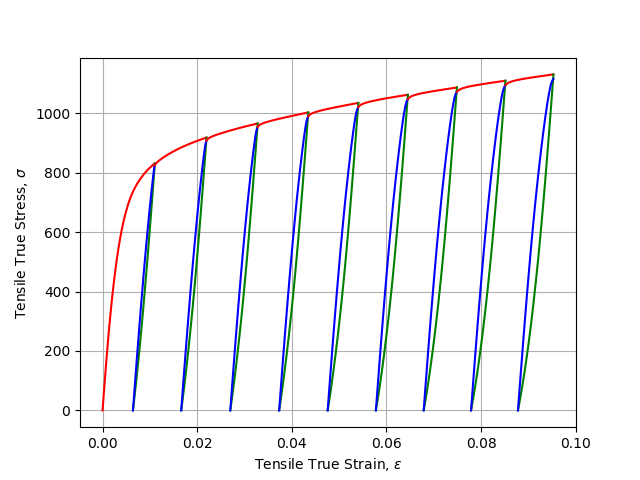

In [28]:
plt.figure()
for i in data.step.s.unique():
    step = data[data.step.s == i]
    color = "rgb"[i%3]
    plt.plot(step.strains.LE11, step.stress.S11, "-" + color, 
             label = "step {0}".format(i))
plt.xlabel(r"Tensile True Strain, $\varepsilon$")
plt.ylabel(r"Tensile True Stress, $\sigma$")
plt.grid()
plt.show()

## Moduli calculation

In [47]:
def modulus(strain, stress, low, high, order = 1):
    smax = stress.max()
    loc = (stress <= high * smax) & (stress >= low * smax)
    stress = stress[loc]
    strain = strain[loc]
    E = np.poly1d(np.polyfit(strain, stress, order)).deriv(1)(smax)
    return E

steps = data.step.s.unique()
moduli = pd.DataFrame(columns = ["epsmax", "epsp", "mic",
                              "E1wag", "E2wag", "E3wag", "E4wag", ])
trash, nc = moduli.shape
Ncycle = int(len(steps)/3)
for i in range(Ncycle):
    U = data[data.step.s == 3*i+1]
    R = data[data.step.s == 3*i+2]
    Eu = U.strains.LE11.values
    Su = U.stress.S11.values
    Er = R.strains.LE11.values
    Sr = R.stress.S11.values
    moduli.loc[m*nc+i, "mic"] = m
    moduli.loc[m*nc+i, "epsmax"] = Eu.max()
    moduli.loc[m*nc+i, "epsp"] = Eu.min()
    moduli.loc[m*nc+i, "E1wag"] = modulus(Eu, Su, .7, 1.)
    moduli.loc[m*nc+i, "E2wag"] = modulus(Eu, Su, 0., .4)
    moduli.loc[m*nc+i, "E3wag"] = modulus(Er, Sr, 0., .3)
    moduli.loc[m*nc+i, "E4wag"] = modulus(Er, Sr, .6, 1.)
    moduli.loc[m*nc+i, "Ecwag"] = Su.max() / (Eu.max() - Eu.min()) 

moduli = moduli.applymap(float)

<IPython.core.display.Javascript object>


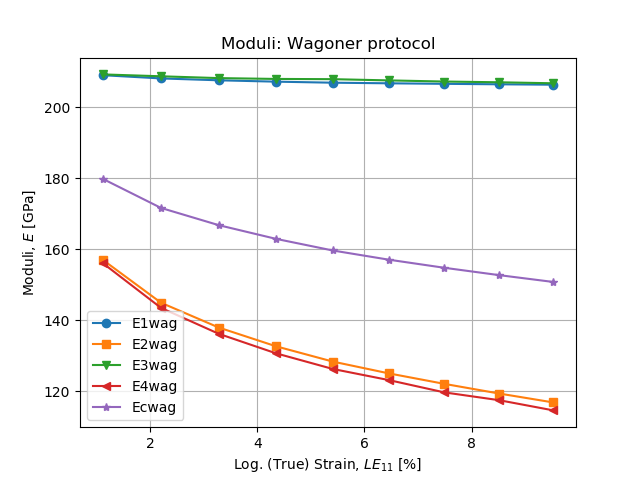

In [48]:
markers = "osv<*"
colors = "rgbmy"
mod = ["E1wag", "E2wag", "E3wag", "E4wag", "Ecwag"]
fig = plt.figure()
for i in range(len(mod)):
    plt.plot(moduli.epsmax * 100., moduli[mod[i]].values / 1000., markers[i] + "-", label = mod[i])
plt.grid()
plt.title("Moduli: Wagoner protocol")
plt.legend(loc = "best")
plt.xlabel("Log. (True) Strain, $LE_{11}$ [%]")
plt.ylabel("Moduli, $E$ [GPa]")
plt.show()


## Deformed state 3D plot

In [50]:
step_label = "loading8"
frame = -1
field_label = "LE"
component_label = "v11"

# FIELDS MANAGEMENT
fdata = model.parts["sample"].mesh.fields_metadata()
fields = model.parts["sample"].mesh.fields
F_id = fdata[(fdata.step_label == step_label) & (fdata.label == field_label)].sort_values("frame").index[frame]
F = fields[F_id].data[component_label]
fdata.head()

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,EE,ISAMPLE,element,loading0,0
1,0,0,LE,ISAMPLE,element,loading0,0
2,0,0,PE,ISAMPLE,element,loading0,0
3,0,0,S,ISAMPLE,element,loading0,0
4,0,0,U,ISAMPLE,node,loading0,0


<IPython.core.display.Javascript object>


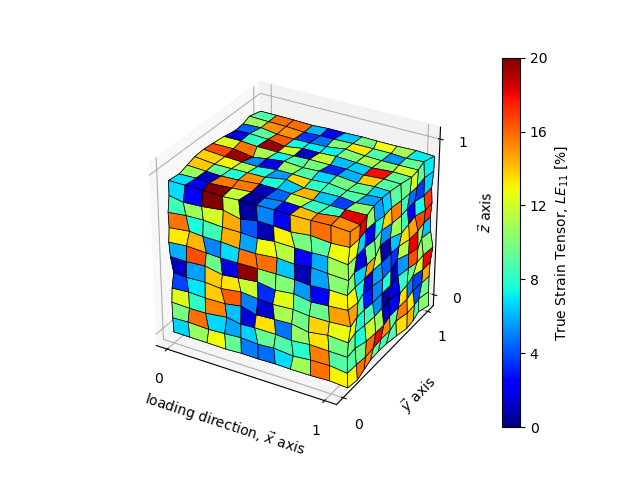

In [51]:
# PATCHES
vertices, emap = model.get_Poly3DCollection(deformed = True, 
                                            step_label = step_label, 
                                            frame = frame, 
                                            displacement_factor = 1.)
        
collection = mpl3d.art3d.Poly3DCollection(vertices)
collection.set_array(F.loc[emap] * 100)
collection.set_linewidth(.5)
collection.set_edgecolor("black")
collection.set_cmap(mpl.cm.jet)
collection.set_clim(0., 20.)

# FIGURE
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d', aspect = "equal")
ax1.add_collection3d(collection)
#ax1.axis("off")
ax1.set_xlabel(r'loading direction, $\vec x$ axis')
ax1.set_ylabel(r'$\vec y$ axis')
ax1.set_zlabel(r'$\vec z$ axis')
offset = .05
ax1.set_xlim3d(-offset, 1. + offset)
ax1.set_ylim3d(-offset, 1. + offset)
ax1.set_zlim3d(-offset, 1. + offset)
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_zticks([0, 1])
cbar = plt.colorbar(collection)
cbar.set_label(r"True Strain Tensor, $LE_{11}$ [$\%$]")
cbar.set_ticks(np.linspace(0., 20, 6))
plt.savefig("model.pdf")
plt.show()